<a href="https://colab.research.google.com/github/yifengd/adversarial-nlp/blob/main/defenses/captum/catum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Based on: Explain Attacking BERT models using CAptum

Captum is a PyTorch library to explain neural networks
Here we show a minimal example using Captum to explain BERT models from TextAttack

[![Open Notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yifengd/adversarial-nlp/blob/main/defenses/captum/catum.ipynb)

[![Original Code on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/QData/TextAttack/blob/master/docs/2notebook/Example_5_Explain_BERT.ipynb)

In [ ]:
!pip install textattack[tensorflow] tensorflow_text==2.10.0b2 captum nltk plotly-express -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from copy import deepcopy
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
# from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import HuggingFaceModelWrapper
# from textattack.models.wrappers import ModelWrapper
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")
    
print(f"Using accelerator {device}")

Using accelerator cuda:0


## Configure Model and Dataset

In [ ]:
# dataset = HuggingFaceDataset("ag_news", None, "train")
original_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-ag-news")
original_tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news")
model = HuggingFaceModelWrapper(original_model,original_tokenizer)

In [ ]:
print(model.model)

## Load Dataframe with Original and Perturbed Samples

In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/NLP-Lab/AdversarialXAI'
adversarial_df = pd.read_csv(f"{DRIVE_PATH}/Adversarial Samples/Older attacks/ag-news_pwws_bert.csv")

In [ ]:
def class_name_to_index(class_name):
  if class_name == "World":
    return 0
  elif class_name == "Sports":
    return 1
  elif class_name == "Business":
    return 2
  elif class_name == "Sci/tech":
    return 3
  else:
    raise ValueError(class_name)

adversarial_df['original_class'] = adversarial_df['original_class'].map(class_name_to_index)
adversarial_df['adversarial_class'] = adversarial_df['adversarial_class'].map(class_name_to_index)

In [ ]:
adversarial_df

,Unnamed: 0,original_text,adversarial_text,original_class,original_confidence,adversarial_class,adversarial_confidence,attack,replace_dict,replace_num
0,0,Fed lifts rates a further quarter point By And...,course lifts grass a further quarter taper pas...,2,(100%),1,(78%),pwws,"{'Fed': 'course', 'rates': 'grass', 'point': '...",6
1,1,Indian-Americans hail Manmohan speech New York...,Indian-Americans come Manmohan delivery New Yo...,0,(100%),2,(62%),pwws,"{'hail': 'come', 'speech': 'delivery', 'meetin...",4
2,2,"Unisys to lay off 1,400 workers Unisys Corp. p...","Unisys to lay off 1,400 workers Unisys Corp. p...",3,(95%),2,(80%),pwws,{'cuts': 'skip'},1
3,3,Dollar Mired Near Lows Before Jobs Data LONDO...,Dollar involved Near Low earlier occupation Da...,2,(100%),0,(97%),pwws,"{'Mired': 'involved', 'Lows': 'Low', 'Before':...",13
4,4,"Keep quiet on U.S. election, Martin tells loos...","sustain calm on uracil.siemens. election, Mart...",0,(100%),1,(81%),pwws,"{'Keep': 'sustain', 'quiet': 'calm', 'U.S.': '...",13
...,...,...,...,...,...,...,...,...,...,...
419,419,EU draft draws fire in Turkey BRUSSELS: Turkey...,EEC potation haulage terminate in Turkey BRUSS...,0,(100%),2,(69%),pwws,"{'EU': 'EEC', 'draft': 'potation', 'draws': 'h...",4
420,420,U.S. Spies on Chat Rooms Could terrorists be p...,u.sec. espy on Chat Rooms Could terrorists be ...,3,(100%),2,(52%),pwws,"{'U.S.': 'U.sulphur.', 'Spies': 'espy'}",2
421,421,Stocks Climb on Drop in Consumer Prices NEW YO...,Stocks Climb on Drop in Consumer Prices Modern...,0,(100%),2,(96%),pwws,"{'NEW': 'Modern', 'Stocks': 'line', 'prices......",3
422,422,Sanpaolo and Dexia in merger talks By Reuters ...,Sanpaolo and Dexia in unification dialogue By ...,2,(100%),0,(99%),pwws,"{'merger': 'unification', 'talks': 'dialogue',...",6


## Calculate Attributions in Original and Perturbed Samples

In [ ]:
from captum.attr import Occlusion, DeepLift, IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerDeepLiftShap, InternalInfluence, LayerGradientXActivation, LayerActivation
from captum.attr import visualization as viz

SUM = False

def calculate(input_ids,token_type_ids,attention_mask):
    #convert back to list of text
    return clone.model(input_ids,token_type_ids,attention_mask)[0]

clone = deepcopy(model)
clone.model.to(device)

for text_type in ["original", "adversarial"]:
  # lig = LayerActivation(calculate, clone.model.bert.encoder.layer[8])
  lig = LayerIntegratedGradients(calculate, clone.model.bert.encoder.layer[3])
  # lig = InternalInfluence(calculate, clone.model.bert.embeddings)
  #lig = LayerGradientXActivation(calculate, clone.model.bert.encoder.layer[8])
  # lig = LayerDeepLiftShap(calculate, clone.model.bert.embeddings)
  # lig = IntegratedGradients(calculate, clone)
  # lig = LayerConductance(calculate, clone.model.bert.embeddings)
  #lig = DeepLift(calculate, clone.model)

  tokens = model.tokenizer([sentence for sentence in adversarial_df[f"{text_type}_text"]], padding="max_length", max_length=128, return_tensors="pt").to(device)
  adversarial_df[f"{text_type}_tokens"] = [tokens[x].tokens for x in range(tokens.input_ids.shape[0])]

  # bsl = torch.zeros(tokens['input_ids'].size()).type(torch.LongTensor).to(device)
  labels = [i for i in adversarial_df[f"{text_type}_class"]]
  labels = torch.tensor(labels).to(device)
  batch_size = 100

  attributions = []

  for i in range(0, len(tokens['input_ids']), batch_size): # range((len(tokens['input_ids']) // batch_size) + 1):
    attributions_next = lig.attribute(inputs=tokens['input_ids'][i:i+batch_size],
                                  #baselines=bsl,
                                  additional_forward_args=(tokens['token_type_ids'][i:i+batch_size], tokens['attention_mask'][i:i+batch_size]),
                                  #n_steps = 10,
                                  target = labels[i:i+batch_size],
                                  internal_batch_size=1
                                  )
    attributions.append(attributions_next)
    
  attributions = torch.cat(attributions)

  # Neuron attribution
  for i in range(len(attributions[0][0])):
    adversarial_df[f"{text_type}_attribution_neuron{i}"] = (attributions[:, :, i] * tokens.attention_mask).cpu().detach().numpy().tolist()

  if SUM:
    atts = attributions.sum(dim=-1).squeeze(0)
    adversarial_df[f"{text_type}_attribution"] = (atts * tokens.attention_mask).cpu().detach().numpy().tolist()
  else:
    atts = attributions
    adversarial_df[f"{text_type}_attribution"] = (atts * tokens.attention_mask.unsqueeze(-1)).cpu().detach().numpy().tolist()

  

## Inspect Attributions

In [ ]:
adversarial_df

,Unnamed: 0,original_text,adversarial_text,original_class,original_confidence,adversarial_class,adversarial_confidence,attack,replace_dict,replace_num,original_tokens,original_attribution,adversarial_tokens,adversarial_attribution
0,0,Fed lifts rates a further quarter point By And...,course lifts grass a further quarter taper pas...,2,(100%),1,(78%),pwws,"{'Fed': 'course', 'rates': 'grass', 'point': '...",6,"[[CLS], fed, lifts, rates, a, further, quarter...","[-0.0010046032681283097, -0.07961424279108309,...","[[CLS], course, lifts, grass, a, further, quar...","[-0.06918606675224276, 0.016937828795091855, 0..."
1,1,Indian-Americans hail Manmohan speech New York...,Indian-Americans come Manmohan delivery New Yo...,0,(100%),2,(62%),pwws,"{'hail': 'come', 'speech': 'delivery', 'meetin...",4,"[[CLS], indian, -, americans, hail, man, ##mo,...","[0.004214206320929344, 0.0547144326151807, -0....","[[CLS], indian, -, americans, come, man, ##mo,...","[-0.00809572923706425, -0.017988591315140072, ..."
2,2,"Unisys to lay off 1,400 workers Unisys Corp. p...","Unisys to lay off 1,400 workers Unisys Corp. p...",3,(95%),2,(80%),pwws,{'cuts': 'skip'},1,"[[CLS], un, ##is, ##ys, to, lay, off, 1, ,, 40...","[0.05369191680668974, 0.289507599557722, -0.09...","[[CLS], un, ##is, ##ys, to, lay, off, 1, ,, 40...","[-0.003745210262823731, -0.03724553685602709, ..."
3,3,Dollar Mired Near Lows Before Jobs Data LONDO...,Dollar involved Near Low earlier occupation Da...,2,(100%),0,(97%),pwws,"{'Mired': 'involved', 'Lows': 'Low', 'Before':...",13,"[[CLS], dollar, mir, ##ed, near, low, ##s, bef...","[-0.0329054169271801, -0.03008665960321779, -0...","[[CLS], dollar, involved, near, low, earlier, ...","[0.03676685868809743, -0.029405763584296942, 0..."
4,4,"Keep quiet on U.S. election, Martin tells loos...","sustain calm on uracil.siemens. election, Mart...",0,(100%),1,(81%),pwws,"{'Keep': 'sustain', 'quiet': 'calm', 'U.S.': '...",13,"[[CLS], keep, quiet, on, u, ., s, ., election,...","[0.028965535417025613, -0.015516203515649914, ...","[[CLS], sustain, calm, on, ur, ##ac, ##il, ., ...","[-0.059925733509268456, -0.18665527212991773, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,419,EU draft draws fire in Turkey BRUSSELS: Turkey...,EEC potation haulage terminate in Turkey BRUSS...,0,(100%),2,(69%),pwws,"{'EU': 'EEC', 'draft': 'potation', 'draws': 'h...",4,"[[CLS], eu, draft, draws, fire, in, turkey, br...","[0.015383225162323499, 0.0707111797268563, 0.0...","[[CLS], ee, ##c, pot, ##ation, haul, ##age, te...","[-0.012478026781326724, 0.035371174606551696, ..."
420,420,U.S. Spies on Chat Rooms Could terrorists be p...,u.sec. espy on Chat Rooms Could terrorists be ...,3,(100%),2,(52%),pwws,"{'U.S.': 'U.sulphur.', 'Spies': 'espy'}",2,"[[CLS], u, ., s, ., spies, on, chat, rooms, co...","[0.036245114440545956, 0.22454895760394755, -0...","[[CLS], u, ., sec, ., es, ##py, on, chat, room...","[-0.009672201070293873, -0.015393307341682708,..."
421,421,Stocks Climb on Drop in Consumer Prices NEW YO...,Stocks Climb on Drop in Consumer Prices Modern...,0,(100%),2,(96%),pwws,"{'NEW': 'Modern', 'Stocks': 'line', 'prices......",3,"[[CLS], stocks, climb, on, drop, in, consumer,...","[0.029328244601740928, 0.09609916033456839, 0....","[[CLS], stocks, climb, on, drop, in, consumer,...","[-0.01978210337318375, -0.0938022849187038, -0..."
422,422,Sanpaolo and Dexia in merger talks By Reuters ...,Sanpaolo and Dexia in unification dialogue By ...,2,(100%),0,(99%),pwws,"{'merger': 'unification', 'talks': 'dialogue',...",6,"[[CLS], san, ##pa, ##olo, and, dex, ##ia, in, ...","[-0.014634846544335705, -0.03371703353330793, ...","[[CLS], san, ##pa, ##olo, and, dex, ##ia, in, ...","[0.00047768501153783345, -0.08671684948504405,..."


## Visual Inspection

### Plot the difference between original and adversarial samples in activations

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0)

#fig = go.Figure(data=go.Heatmap(z=attributions[0].cpu().detach()))

i = 20
samples = [elems for elems in adversarial_df["original_tokens"][i] if elems != "[PAD]"].__len__()
orig = np.array(adversarial_df["original_attribution"][i])[:samples,:]
adv = np.array(adversarial_df["adversarial_attribution"][i])[:samples,:]
diff = orig - adv

fig.add_trace(
    go.Heatmap(z=orig),
    row=1, col=1
)

fig.add_trace(
    go.Heatmap(z=adv),
    row=2, col=1
)

fig.add_trace(
    go.Heatmap(z=diff),
    row=3, col=1
)

fig.add_trace(
    go.Heatmap(z=diff),
    row=3, col=1
)

fig.update_layout(
    height=800,
    width=1500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0,
    ),
    font=dict(
        size=15,
    )
)
fig.show()

### Attributions by Neuron

In [ ]:
for i in range(768):
  adversarial_df[f"attribution_neuron{i}"] = np.square(np.subtract(
      adversarial_df[f"original_attribution_neuron{i}"].to_list(),
      adversarial_df[f"adversarial_attribution_neuron{i}"].to_list()
    )).sum(axis=1)
  
attribution_layer_cols = [c for c in adversarial_df.columns if c.startswith("attribution_neuron")]
pd.DataFrame(adversarial_df[attribution_layer_cols].sum()).sort_values(by=0, ascending=False)

,0
attribution_neuron381,26.907034
attribution_neuron308,5.649755
attribution_neuron654,3.811647
attribution_neuron345,3.731335
attribution_neuron699,2.473299
...,...
attribution_neuron499,0.022775
attribution_neuron588,0.022336
attribution_neuron249,0.021754
attribution_neuron574,0.019713


### Plot the Attributions by Neuron

In [ ]:
plot_df = pd.DataFrame(adversarial_df[attribution_layer_cols].sum()).sort_values(by=0, ascending=False).head(50)
fig = go.Figure(go.Scatter(x=plot_df.index, y=plot_df[0], mode='lines+markers'))
fig.update_layout(
    height=700,
    width=1000,
    template="ggplot2",
    font=dict(
        size=15,
    )
)

### Plot Attributions of Original and Perturbed Samples

0      42240
1      41472
2      46848
3      45312
4      44544
       ...  
419    37632
420    43008
421    59136
422    57600
423    20736
Name: original_attribution, Length: 424, dtype: int64
0      43008
1      41472
2      46848
3      44544
4      46848
       ...  
419    39936
420    45312
421    59136
422    59904
423    26880
Name: adversarial_attribution, Length: 424, dtype: int64


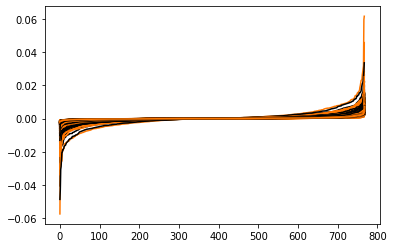

In [ ]:
num_rows, _ = adversarial_df.shape
fig, ax = plt.subplots()
for i in range(num_rows):
  ax.plot(np.sort(adversarial_df.iloc[i].original_attribution[0]), color="black")
  ax.plot(np.sort(adversarial_df.iloc[i].adversarial_attribution[0]), color="#FF7700")

lens = adversarial_df['original_attribution'].apply(lambda x: len(np.array(x)[np.array(x) != 0]))
print(lens)
lens = adversarial_df['adversarial_attribution'].apply(lambda x: len(np.array(x)[np.array(x) != 0]))
print(lens)